Selected codes: {'youth_pop': 'SP.POP.1564.TO.ZS', 'internet_users': 'IT.NET.USER.P2', 'tertiary_enrol': 'SE.TER.ENRR'}
✅ Saved ranking with 73 countries


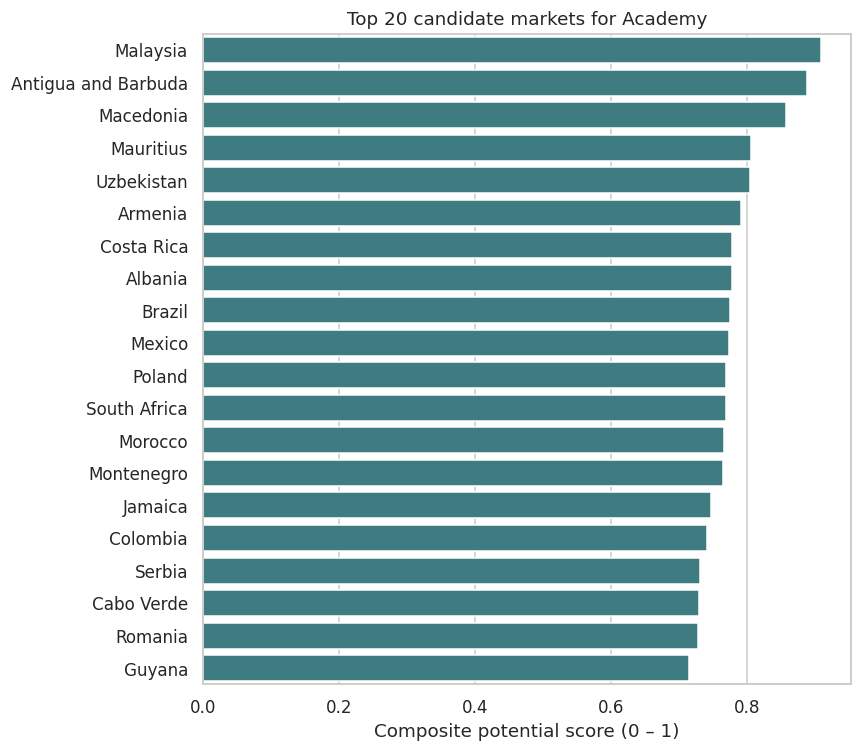

In [37]:
from pathlib import Path
import re
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_theme(style="whitegrid")
plt.rcParams["figure.dpi"] = 110

# ------------------------------------------------------------------
# 0. Paths & parameters
# ------------------------------------------------------------------
DATA_DIR   = Path("./cleaned_data")
COUNTRIES  = DATA_DIR / "EdStatsCountry_cleaned.csv"
DATA       = DATA_DIR / "EdStatsData_cleaned.csv"

YEAR_MIN, YEAR_MAX = 2010, 2030
TARGET_YEAR        = 2024
TOP_N              = 20

# ------------------------------------------------------------------
# Codes **present** in the cleaned dataset
# ------------------------------------------------------------------
INDICATOR_CANDIDATES = {
    # Share of population aged 15–64 (% of total population)
    # (best youth-size proxy available after cleaning)
    "youth_pop"      : ["SP.POP.1564.TO.ZS"],
    # Internet users – number of people
    "internet_users" : ["IT.NET.USER.P2"],
    # Gross tertiary enrolment ratio (%)
    "tertiary_enrol" : ["SE.TER.ENRR"],
}

# ------------------------------------------------------------------
# 1. Country metadata  ➜  keep only sovereign ISO-3 codes
# ------------------------------------------------------------------
countries = (
    pd.read_csv(COUNTRIES, usecols=["Country Code", "Short Name",
                                    "Region", "Income Group"])
    .query("`Country Code`.str.len() == 3")          # ISO-3 only
    .query("Region.notna() and Region != 'Aggregates'")
)

# save the list for quick membership tests
country_set = set(countries["Country Code"])

# ------------------------------------------------------------------
# 2. Stream-load indicator data, filtering on two dimensions at once
# ------------------------------------------------------------------
all_codes = {c for lst in INDICATOR_CANDIDATES.values() for c in lst}

rows = []
for chunk in pd.read_csv(
        DATA,
        chunksize=30_000,
        low_memory=False,
        usecols=lambda c: c == "Country Code"          # meta cols
                          or c == "Indicator Code"
                          or (c.isdigit()                # year cols
                              and YEAR_MIN <= int(c) <= YEAR_MAX)
):
    rows.append(
        chunk[
            chunk["Indicator Code"].isin(all_codes)
            & chunk["Country Code"].isin(country_set)   # ← early filter!
            ]
    )

raw = pd.concat(rows, ignore_index=True)

# ------------------------------------------------------------------
# 3. Year columns within range
# ------------------------------------------------------------------
year_cols = [
    c for c in raw.columns
    if re.match(r"^\d{4}", c) and YEAR_MIN <= int(c[:4]) <= YEAR_MAX
]

# pick the best code (most data rows) for each concept
best_codes = {}
for concept, cands in INDICATOR_CANDIDATES.items():
    counts = {
        code: (
            raw.loc[raw["Indicator Code"] == code, year_cols]
            .apply(pd.to_numeric, errors="coerce")
            .notna()
            .any(axis=1)
            .sum()
        )
        for code in cands
    }
    usable = {k: v for k, v in counts.items() if v > 0}
    best_codes[concept] = max(usable, key=usable.get)
print("Selected codes:", best_codes)

# ------------------------------------------------------------------
# 4. Build tidy table with **latest value only**
# ------------------------------------------------------------------
def pick_latest(df):
    ordered = sorted(
        [c for c in df.columns if int(c[:4]) <= TARGET_YEAR],
        key=lambda x: int(x[:4]),
        reverse=True,
    )
    return df[ordered].apply(pd.to_numeric, errors="coerce").bfill(axis=1).iloc[:, 0]

tidy_parts = []
for concept, code in best_codes.items():
    block = raw[raw["Indicator Code"] == code].set_index("Country Code")
    tidy_parts.append(
        pd.DataFrame(
            {
                "Country Code": block.index,
                "Concept"     : concept,
                "latest_val"  : pick_latest(block[year_cols]).values,
            }
        )
    )
tidy = pd.concat(tidy_parts)

# ------------------------------------------------------------------
# 5. Pivot wide
# ------------------------------------------------------------------
wide = (
    tidy.pivot(index="Country Code",
               columns="Concept",
               values="latest_val")
    .reset_index()
    .merge(countries, on="Country Code", how="left")
)

# ------------------------------------------------------------------
# 6. Feature scaling & composite score
# ------------------------------------------------------------------
def minmax(s):
    v = s.dropna()
    if v.empty: return pd.Series(np.nan, index=s.index)
    if (mx := v.max()) == (mn := v.min()): return pd.Series(0.5, index=s.index)
    return (s - mn) / (mx - mn)

# Scores
# youth_pop is already a percentage, so no log-scaling
wide["pop_score"]       = minmax(wide["youth_pop"])
wide["internet_score"]  = minmax(wide["internet_users"])
tertiary_scaled         = minmax(wide["tertiary_enrol"])
wide["tertiary_gap"]    = 1 - tertiary_scaled

# Weights (sum to 1)
weights = dict(size=0.4, internet=0.3, gap=0.3)

wide["potential_score"] = (
        weights["size"]      * wide["pop_score"]
        + weights["internet"]  * wide["internet_score"]
        + weights["gap"]       * wide["tertiary_gap"]
)

# ------------------------------------------------------------------
# 7. Ranking & export
# ------------------------------------------------------------------
ranking = (
    wide[["Country Code", "Short Name", "Region", "Income Group",
          "potential_score"]]
    .dropna(subset=["potential_score"])
    .sort_values("potential_score", ascending=False)
    .reset_index(drop=True)
)

ranking.to_csv("country_potential_scores_simple.csv", index=False)
print(f"✅ Saved ranking with {ranking.shape[0]} countries")

# ------------------------------------------------------------------
# 8. bar chart
# ------------------------------------------------------------------
plt.figure(figsize=(8, TOP_N * 0.35))
sns.barplot(data=ranking.head(TOP_N),
            y="Short Name",
            x="potential_score",
            color=sns.color_palette("crest", n_colors=1)[0])
plt.title(f"Top {TOP_N} candidate markets for Academy")
plt.xlabel("Composite potential score (0 – 1)")
plt.ylabel("")
plt.tight_layout()
plt.savefig("top_countries_potential_simple.png", dpi=300)
plt.show()


### How to Read This Chart
What’s shown:
This “pairplot” provides a grid of scatterplots and density plots, comparing all combinations of your main scoring features:

- pop_score: Scaled youth population
- internet_score: Scaled internet user count
- tertiary_gap: Unmet demand for tertiary (higher) education
- potential_score: The final composite market potential score

How to interpret:

- Diagonal cells: The density curve (KDE) shows how each feature is distributed among countries (e.g., are most countries bunched up at one end or spread out?).
- Off-diagonal cells: Each scatterplot shows the relationship between a pair of features.
If you see a clear upward (or downward) trend, those features are correlated.
Clusters or outliers may suggest interesting country groups or unexpected patterns.
- This view makes it easy to spot redundant features (if two features are tightly correlated) or identify which features contribute unique information to your scoring.

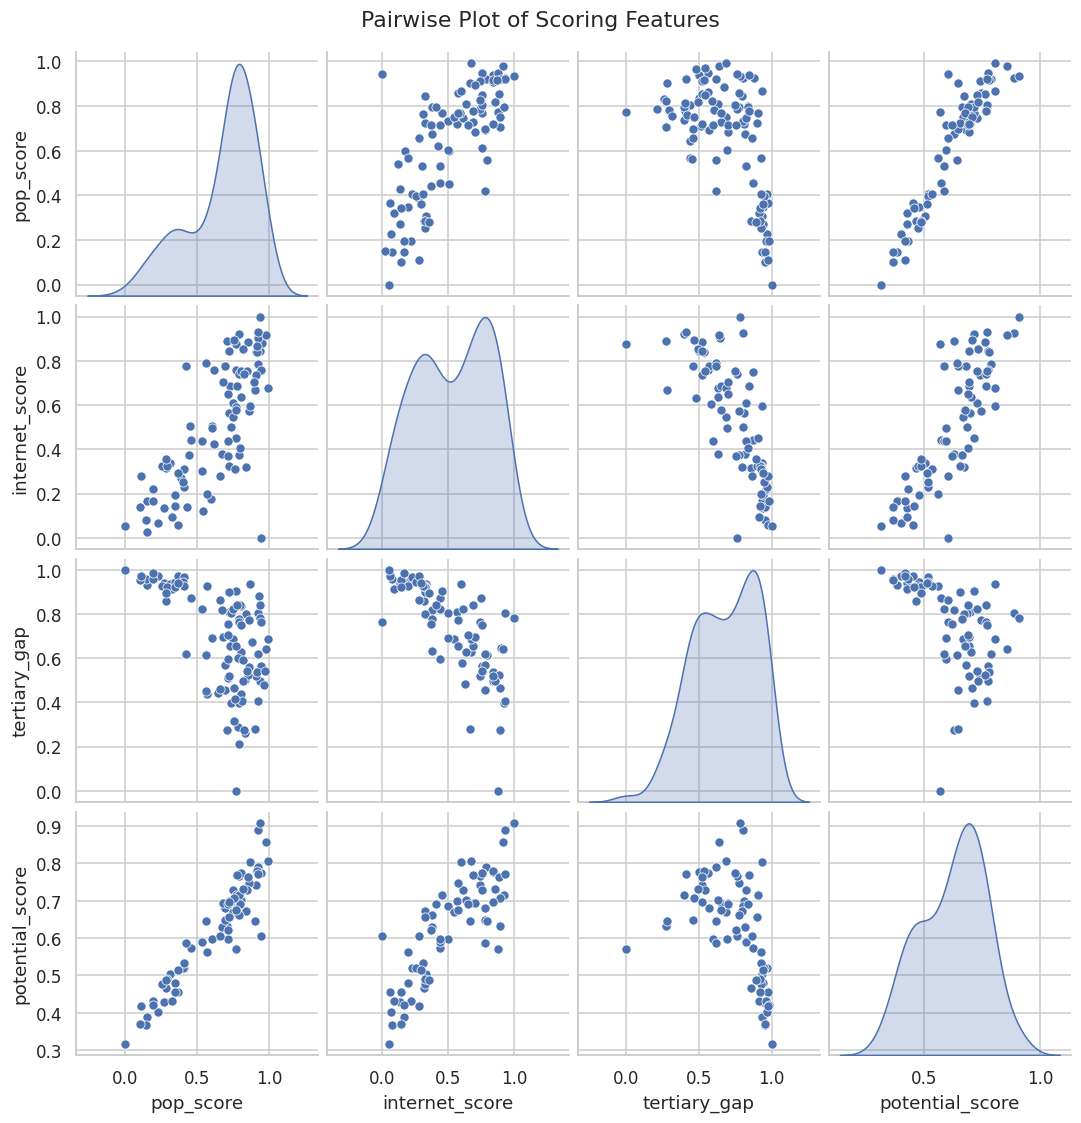

In [38]:
sns.pairplot(
    data=wide[["pop_score", "internet_score", "tertiary_gap", "potential_score"]],
    diag_kind="kde"
)
plt.suptitle("Pairwise Plot of Scoring Features", y=1.02)
plt.show()

### How to read:
This heatmap displays the strength of relationships (correlations) between each scoring component and the final composite score.

- A value close to 1 (dark blue) means two features move together strongly.
- For example, pop_score and potential_score are highly correlated, indicating that countries with a large youth population tend to score higher overall.
- Low or zero correlation means the variables are relatively independent in this sample.

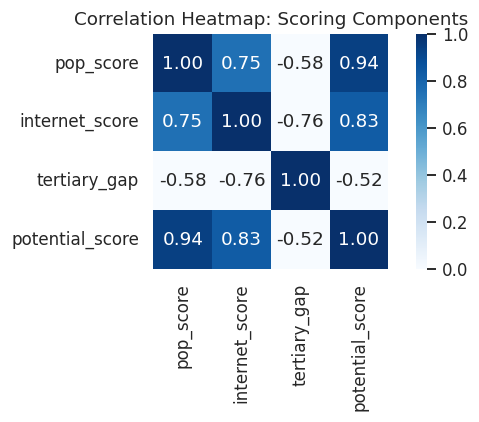

In [39]:
features = ["pop_score", "internet_score", "tertiary_gap", "potential_score"]
corr = wide[features].corr()

plt.figure(figsize=(6, 4))
sns.heatmap(corr, annot=True, cmap="Blues", fmt=".2f", vmin=0, vmax=1, square=True)
plt.title("Correlation Heatmap: Scoring Components")
plt.tight_layout()
plt.show()

### How to read:
Each box represents a region’s distribution of university/college enrolment rates (% of eligible population).

- The line in the middle is the median.
- The box shows the interquartile range (the “middle 50%”).
- Dots (if any) are outliers.
- Regions to the left generally have higher enrolment.

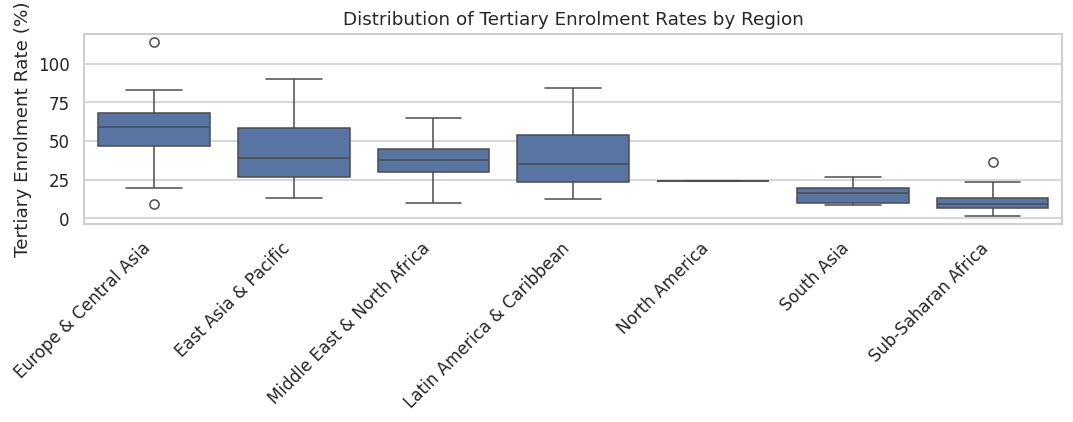

In [40]:
plt.figure(figsize=(10, 4))
sns.boxplot(
    data=wide,
    x="Region", y="tertiary_enrol",
    order=wide.groupby("Region")["tertiary_enrol"].median().sort_values(ascending=False).index
)
plt.title("Distribution of Tertiary Enrolment Rates by Region")
plt.xlabel("")
plt.ylabel("Tertiary Enrolment Rate (%)")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

### How to read:
Each bubble is a country (name labeled), positioned by their youth population score (x) and internet user score (y).
- Bubble size = “tertiary gap” (higher means more unmet demand for higher education).
- Color = potential score.
- Countries toward the top right with big, dark bubbles are best for expansion: large, online youth with big education gaps.

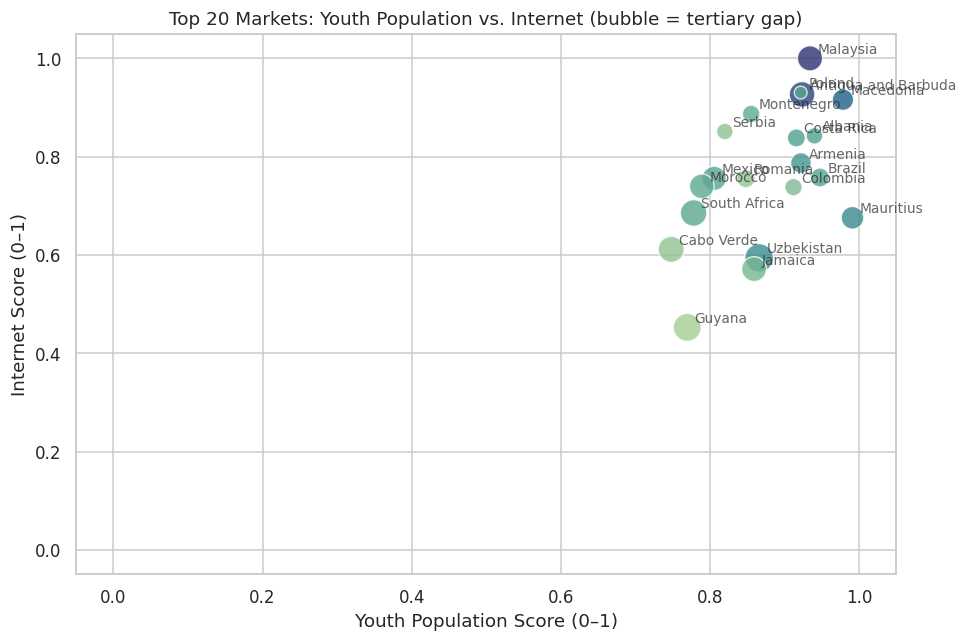

In [41]:
# Ensure you have the right columns in both DataFrames before merging!
wide_subset = wide[["Country Code", "pop_score", "internet_score", "tertiary_gap", "potential_score", "Short Name"]]

# Merge the top 20 with all scoring features
top_countries = (
    ranking.head(20)[["Country Code"]]
    .merge(wide_subset, on="Country Code", how="left")
)

plt.figure(figsize=(9, 6))
scatter = sns.scatterplot(
    data=top_countries,
    x="pop_score", y="internet_score", size="tertiary_gap",
    sizes=(70, 350), hue="potential_score", palette="crest", legend=False, alpha=0.8
)
for i, row in top_countries.iterrows():
    plt.text(
        row["pop_score"] + 0.01, row["internet_score"] + 0.01,
        row["Short Name"], fontsize=9, alpha=0.7
    )
plt.title("Top 20 Markets: Youth Population vs. Internet (bubble = tertiary gap)")
plt.xlabel("Youth Population Score (0–1)")
plt.ylabel("Internet Score (0–1)")
plt.xlim(-0.05, 1.05)
plt.ylim(-0.05, 1.05)
plt.tight_layout()
plt.show()